<a href="https://colab.research.google.com/github/gabriellaaileen/pillar-stability-prediction/blob/main/New_Data_Ver_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Requirements**

In [2]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow import nn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
import tensorflow as tf

In [4]:
!wget -P data/ https://raw.githubusercontent.com/gabriellaaileen/pillar-stability-prediction/main/"Relabel SF6.csv"

--2022-09-12 13:59:36--  https://raw.githubusercontent.com/gabriellaaileen/pillar-stability-prediction/main/Relabel%20SF6.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12591 (12K) [text/plain]
Saving to: ‘data/Relabel SF6.csv’

Relabel SF6.csv     100%[===================>]  12.30K  --.-KB/s    in 0s      

2022-09-12 13:59:36 (73.9 MB/s) - ‘data/Relabel SF6.csv’ saved [12591/12591]



In [5]:
df = pd.read_csv('/content/data/Relabel SF6.csv')

#**Exploratory Data Analysis**

In [ ]:
df.head(5)

,Depth,BW,PW,MH,Ratio,Stability,Relabel_6
0,76.2,6.10,4.88,1.37,3.562044,Failed,Failed
1,87.8,6.10,6.10,1.98,3.080808,Failed,Failed
2,55.5,6.62,7.43,3.80,1.955263,Failed,Failed
3,78.2,6.47,10.53,5.16,2.040698,Failed,Failed
4,73.5,6.60,8.40,3.65,2.301370,Failed,Failed


In [ ]:
df.shape

(290, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Depth      290 non-null    float64
 1   BW         290 non-null    float64
 2   PW         290 non-null    float64
 3   MH         290 non-null    float64
 4   Ratio      290 non-null    float64
 5   Stability  290 non-null    object 
 6   Relabel_6  290 non-null    object 
dtypes: float64(5), object(2)
memory usage: 16.0+ KB


In [ ]:
#Menghitung presentase missing values dari masing-masing variabel
(df.isnull().sum()/len(df)*100).to_frame('Persentase Missing Value Dataset (%)')

,Persentase Missing Value Dataset (%)
Depth,0.0
BW,0.0
PW,0.0
MH,0.0
Ratio,0.0
Stability,0.0
Relabel_6,0.0


In [ ]:
df.describe()

,Depth,BW,PW,MH,Ratio
count,290.000000,290.000000,290.000000,290.000000,290.000000
mean,77.193448,6.039379,10.359483,2.845724,4.086694
std,46.767135,0.590025,5.269283,1.093174,2.520439
min,13.220000,3.690000,2.910000,1.000000,0.866521
25%,41.025000,5.840000,6.160000,2.000000,2.377593
50%,62.490000,6.000000,9.140000,2.800000,3.422189
75%,101.157500,6.300000,12.800000,3.500000,5.009494
max,223.380000,8.530000,35.000000,6.200000,16.190476


In [ ]:
print(df.groupby(['Relabel_6']).agg({"Relabel_6": "count"}), end="\n\n\n")

           Relabel_6
Relabel_6           
Failed            65
Intact           195
Unstable          30




In [ ]:
import plotly.io as pio
import plotly.express as px
import plotly.offline as py

fig = px.scatter(df, x="Depth", y="PW", color="Stability", size="BW")
fig

#**Preprocessing**

In [6]:
df = df.drop(['Stability','Ratio'], axis=1)

##Imbalance dataset

In [7]:
X, y = df.drop('Relabel_6', axis=1),df['Relabel_6']

###Oversampling

In [8]:
# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [9]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

###Hasil

In [10]:
df=pd.concat([X_resampled, y_resampled], axis=1)
df.head()

,Depth,BW,PW,MH,Relabel_6
0,76.2,6.10,4.88,1.37,Failed
1,87.8,6.10,6.10,1.98,Failed
2,55.5,6.62,7.43,3.80,Failed
3,78.2,6.47,10.53,5.16,Failed
4,73.5,6.60,8.40,3.65,Failed


In [11]:
print(df.groupby(['Relabel_6']).agg({"Relabel_6": "count"}), end="\n\n\n")

           Relabel_6
Relabel_6           
Failed           195
Intact           195
Unstable         195




##Label Encoding

In [12]:
#Split dataset menjadi feature (X) dan label (y)
y = df['Relabel_6']
X = df.drop(columns=['Relabel_6'])

In [13]:
le = LabelEncoder()
y = le.fit_transform(y)

In [14]:
dictionary={}
for i in range(len(list(le.classes_))):
  dictionary[list(le.classes_)[i]]=i
dictionary

{'Failed': 0, 'Intact': 1, 'Unstable': 2}

##Split Dataset (Train - Val - Test)

**Train - Test Split**

In [106]:
#Split train dan test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

**Train - Val - Test Split**

In [133]:
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.75
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.75)

In [17]:
X_train.shape

(409, 4)

In [18]:
X_valid.shape

(88, 4)

In [19]:
X_test.shape

(88, 4)

#**Build Model**

In [ ]:
adam = Adam(learning_rate=0.001)

In [ ]:
#Callback
callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    mode='auto'
)

##Model 1 (Activation function: Linear)

In [ ]:
model_1 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])

In [ ]:
model_1.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               2560      
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                                 
Total params: 232,963
Trainable params: 232,963
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_1.fit(X_train, y_train, batch_size=16, epochs=400, callbacks=callback,  verbose=1)

In [ ]:
history = model_1.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size=16, epochs=100,  verbose=1)

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 15.8787 - accuracy: 0.3203 - val_loss: 7.7960 - val_accuracy: 0.3409
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 2.3442 - accuracy: 0.4230 - val_loss: 1.1072 - val_accuracy: 0.5568
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9471 - accuracy: 0.5501 - val_loss: 0.9541 - val_accuracy: 0.5114
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8855 - accuracy: 0.6161 - val_loss: 0.7973 - val_accuracy: 0.6136
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8066 - accuracy: 0.6406 - val_loss: 1.0739 - val_accuracy: 0.4318
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9239 - accuracy: 0.5623 - val_loss: 0.7683 - val_accuracy: 0.6023
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.6919 - val_loss: 0.7156 - val_accuracy: 0.7386
Epoch 8/100


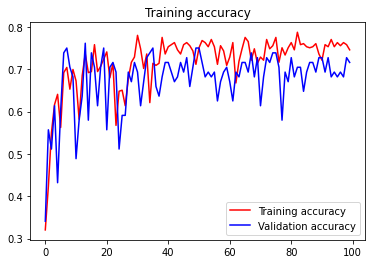

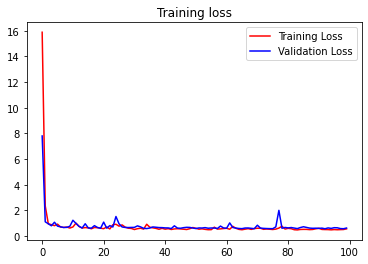

In [ ]:
# Visualize Loss & Accuracy
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
model_1.evaluate(X_test, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 0.5542 - accuracy: 0.7273


[0.5542144179344177, 0.7272727489471436]

In [ ]:
model_1.evaluate(X_train, y_train)

13/13 [==============================] - 0s 1ms/step - loss: 0.5218 - accuracy: 0.7702


[0.5217604637145996, 0.7701711654663086]

##Model 2 (Activation function: ReLU)

In [ ]:
model_2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])

In [ ]:
model_2.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])

In [ ]:
model_2.summary()

In [ ]:
history = model_2.fit(X_train, y_train, batch_size=16, epochs=400, callbacks=callback, verbose=1)

In [ ]:
history = model_2.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size=16, epochs=100, verbose=1)

Epoch 1/100
26/26 [==============================] - 1s 8ms/step - loss: 2.8086 - accuracy: 0.3178 - val_loss: 1.1405 - val_accuracy: 0.3977
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 1.1056 - accuracy: 0.3839 - val_loss: 1.0482 - val_accuracy: 0.5341
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9890 - accuracy: 0.5257 - val_loss: 0.9133 - val_accuracy: 0.5341
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8279 - accuracy: 0.6137 - val_loss: 0.6930 - val_accuracy: 0.7500
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6650 - val_loss: 0.5541 - val_accuracy: 0.6932
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.5927 - accuracy: 0.7139 - val_loss: 0.6273 - val_accuracy: 0.7386
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.5362 - accuracy: 0.7384 - val_loss: 0.5354 - val_accuracy: 0.7273
Epoch 8/100
2

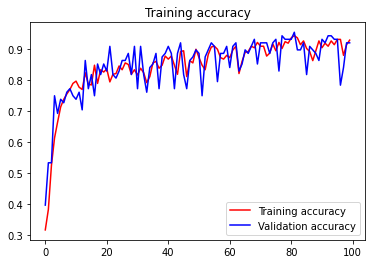

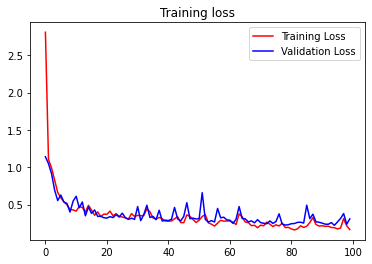

In [ ]:
# Visualize Loss & Accuracy
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
model_2.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.2469 - accuracy: 0.8977


[0.24692033231258392, 0.8977272510528564]

In [ ]:
model_2.evaluate(X_train, y_train)

13/13 [==============================] - 0s 1ms/step - loss: 0.1985 - accuracy: 0.9144


[0.19852496683597565, 0.9144254326820374]

##Model 3

In [ ]:
model_3 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])

In [ ]:
model_3.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])

In [ ]:
history = model_3.fit(X_train, y_train, batch_size=16, epochs=400, callbacks=callback,  verbose=1)

In [ ]:
history = model_3.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size=16, epochs=100,  verbose=1)

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 3.9186 - accuracy: 0.3472 - val_loss: 1.0802 - val_accuracy: 0.3750
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 1.1872 - accuracy: 0.4205 - val_loss: 1.0478 - val_accuracy: 0.5341
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 1.0969 - accuracy: 0.4401 - val_loss: 1.0395 - val_accuracy: 0.4091
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 1.0395 - accuracy: 0.4841 - val_loss: 0.9290 - val_accuracy: 0.6250
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8457 - accuracy: 0.6088 - val_loss: 0.9191 - val_accuracy: 0.5000
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.7270 - accuracy: 0.6553 - val_loss: 0.6528 - val_accuracy: 0.6136
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.5925 - accuracy: 0.7164 - val_loss: 0.5708 - val_accuracy: 0.7159
Epoch 8/100
2

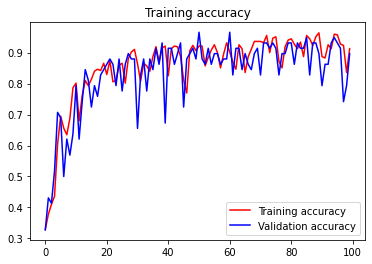

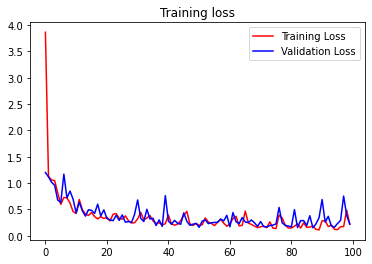

In [ ]:
# Visualize Loss & Accuracy
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
model_3.evaluate(X_test, y_test)

2/2 [==============================] - 0s 5ms/step - loss: 0.2304 - accuracy: 0.9322


[0.23038947582244873, 0.9322034120559692]

In [ ]:
model_3.evaluate(X_train, y_train)

15/15 [==============================] - 0s 1ms/step - loss: 0.1868 - accuracy: 0.9209


[0.1868014633655548, 0.9209401607513428]

##Model 4

In [ ]:
model_4 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])

In [ ]:
model_4.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])

In [ ]:
history = model_4.fit(X_train, y_train, batch_size=16, epochs=400, callbacks=callback,  verbose=1)

In [ ]:
history = model_4.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size=16, epochs=100,  verbose=1)

Epoch 1/100
26/26 [==============================] - 1s 9ms/step - loss: 2.9453 - accuracy: 0.3545 - val_loss: 1.1688 - val_accuracy: 0.3977
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 1.1041 - accuracy: 0.4328 - val_loss: 1.1962 - val_accuracy: 0.3068
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 1.0176 - accuracy: 0.4792 - val_loss: 0.8439 - val_accuracy: 0.5909
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 0.8400 - accuracy: 0.6137 - val_loss: 1.2243 - val_accuracy: 0.5341
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8337 - accuracy: 0.6381 - val_loss: 0.6082 - val_accuracy: 0.7273
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.6846 - val_loss: 0.8473 - val_accuracy: 0.5455
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.7164 - val_loss: 0.4926 - val_accuracy: 0.7841
Epoch 8/100
2

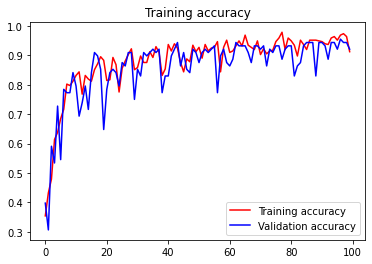

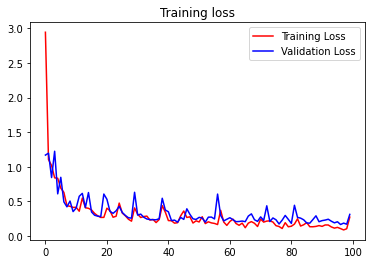

In [ ]:
# Visualize Loss & Accuracy
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
model_4.evaluate(X_test, y_test)

3/3 [==============================] - 0s 4ms/step - loss: 0.2421 - accuracy: 0.9091


[0.24211058020591736, 0.9090909361839294]

In [ ]:
model_4.evaluate(X_train,y_train)

13/13 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.9340


[0.18637190759181976, 0.9339853525161743]

#**Prediction**

In [ ]:
predictions=model_4.predict(X_test, batch_size=None)

In [ ]:
predictions=np.argmax(predictions, axis = 1)

In [ ]:
testing = pd.DataFrame()
testing['Stability'] = y_test
testing['Pred_Stability'] = predictions

In [ ]:
testing.head()

,Stability,Pred_Stability
0,1,2
1,1,2
2,2,1
3,1,1
4,0,0


In [ ]:
print(classification_report(testing['Stability'].values, testing['Pred_Stability'].values, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       1.00      0.77      0.87        31
           2       0.79      1.00      0.88        30

    accuracy                           0.91        88
   macro avg       0.93      0.91      0.91        88
weighted avg       0.93      0.91      0.91        88



In [ ]:
stability_list = list(df['Relabel_6'].unique())

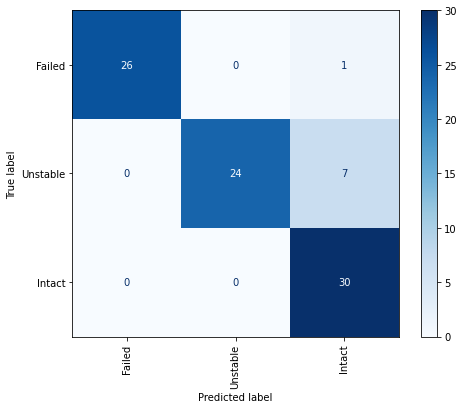

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
matrix = ConfusionMatrixDisplay.from_predictions(testing['Stability'].values, testing['Pred_Stability'].values, display_labels=stability_list, cmap='Blues', ax=ax)
plt.xticks(rotation=90)
plt.show()

#**Training with 10 Folds CV**

##Requirements

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Merge inputs and targets
inputs = np.concatenate((X_train, X_valid), axis=0)
targets = np.concatenate((y_train, y_valid), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

In [ ]:
adam = Adam(learning_rate=0.001)

In [ ]:
#Callback
callback = EarlyStopping(
    monitor="accuracy",
    patience=10,
    restore_best_weights=True,
    mode='auto'
)

In [ ]:
average=[]
def Average(lst):
    return sum(lst) / len(lst)

In [ ]:
test_acc=[]
cv_acc=[]

In [ ]:
train_acc=[]

##Model 1 (Linear)

In [ ]:
acc_per_fold=[]
loss_per_fold=[]

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model_1 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])

  # Compile the model
  model_1.compile(loss="SparseCategoricalCrossentropy",
                optimizer=adam,
                metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model_1.fit(inputs[train], targets[train],
              batch_size=16,
              epochs=100,
              verbose=1,
              callbacks=callback)

  # Generate generalization metrics
  scores = model_1.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model_1.metrics_names[0]} of {scores[0]}; {model_1.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
12/12 [==============================] - 0s 3ms/step - loss: 18.7140 - accuracy: 0.3533
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 6.5211 - accuracy: 0.2772
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 1.5583 - accuracy: 0.4783
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 1.1883 - accuracy: 0.5435
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 1.0704 - accuracy: 0.5163
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 1.2463 - accuracy: 0.4293
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 1.1730 - accuracy: 0.4674
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 0.9164 - accuracy: 0.5272
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.8226 - accuracy: 0.6739
Epoch 10/10

In [ ]:
cv_acc.append(acc_per_fold)

In [ ]:
test_acc.append(model_1.evaluate(X_test,y_test)[1])

15/15 [==============================] - 0s 2ms/step - loss: 0.5376 - accuracy: 0.7607


In [ ]:
train_acc.append(model_1.evaluate(X_train,y_train)[1])

4/4 [==============================] - 0s 2ms/step - loss: 0.5800 - accuracy: 0.7607


In [ ]:
average.append(round(Average(acc_per_fold),2))

##Model 2 (ReLU)

In [ ]:
acc_per_fold=[]
loss_per_fold=[]

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model_2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])

  # Compile the model
  model_2.compile(loss="SparseCategoricalCrossentropy",
                optimizer=adam,
                metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model_2.fit(inputs[train], targets[train],
              batch_size=16,
              epochs=100,
              verbose=1,
              callbacks=callback)

  # Generate generalization metrics
  scores = model_2.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model_2.metrics_names[0]} of {scores[0]}; {model_2.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
12/12 [==============================] - 0s 3ms/step - loss: 3.2790 - accuracy: 0.3315
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3715 - accuracy: 0.3315
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 1.1046 - accuracy: 0.4565
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 1.0735 - accuracy: 0.4620
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 1.0198 - accuracy: 0.4293
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 0.9284 - accuracy: 0.5326
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 0.9650 - accuracy: 0.5435
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.9127 - accuracy: 0.5543
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.7582 - accuracy: 0.6413
Epoch 10/100

In [ ]:
cv_acc.append(acc_per_fold)

In [ ]:
test_acc.append(model_2.evaluate(X_test,y_test)[1])

15/15 [==============================] - 0s 2ms/step - loss: 0.3761 - accuracy: 0.8376


In [ ]:
train_acc.append(model_2.evaluate(X_train,y_train)[1])

4/4 [==============================] - 0s 2ms/step - loss: 0.2955 - accuracy: 0.9060


In [ ]:
average.append(round(Average(acc_per_fold),2))

##Model 3 (ELU)

In [ ]:
acc_per_fold=[]
loss_per_fold=[]

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model_3 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])

  # Compile the model
  model_3.compile(loss="SparseCategoricalCrossentropy",
                optimizer=adam,
                metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model_3.fit(inputs[train], targets[train],
              batch_size=16,
              epochs=100,
              verbose=1,
              callbacks=callback)

  # Generate generalization metrics
  scores = model_3.evaluate(inputs[test], targets[test], verbose=1)
  print(f'Score for fold {fold_no}: {model_3.metrics_names[0]} of {scores[0]}; {model_3.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
12/12 [==============================] - 0s 3ms/step - loss: 6.0606 - accuracy: 0.3587
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 1.9627 - accuracy: 0.4022
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 1.2013 - accuracy: 0.4293
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 1.1214 - accuracy: 0.4674
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 1.1491 - accuracy: 0.3478
Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 0.9698 - accuracy: 0.5109
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.8942 - accuracy: 0.5543
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.8231 - accuracy: 0.5924
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.9764 - accuracy: 0.5000
Epoch 10/100

In [ ]:
cv_acc.append(acc_per_fold)

In [ ]:
test_acc.append(model_3.evaluate(X_test,y_test)[1])

15/15 [==============================] - 0s 2ms/step - loss: 0.3418 - accuracy: 0.8697


In [ ]:
train_acc.append(model_3.evaluate(X_train,y_train)[1])

4/4 [==============================] - 0s 2ms/step - loss: 0.3129 - accuracy: 0.8718


In [ ]:
average.append(round(Average(acc_per_fold),2))

##Model 4 (GELU)

In [ ]:
acc_per_fold=[]
loss_per_fold=[]

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model_4 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])

  # Compile the model
  model_4.compile(loss="SparseCategoricalCrossentropy",
                optimizer=adam,
                metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model_4.fit(inputs[train], targets[train],
              batch_size=16,
              epochs=100,
              verbose=1,
              callbacks=callback)

  # Generate generalization metrics
  scores = model_4.evaluate(inputs[test], targets[test], verbose=1)
  print(f'Score for fold {fold_no}: {model_4.metrics_names[0]} of {scores[0]}; {model_4.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
12/12 [==============================] - 1s 3ms/step - loss: 5.2058 - accuracy: 0.3261
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 1.2144 - accuracy: 0.4293
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 1.0654 - accuracy: 0.3967
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.9757 - accuracy: 0.4348
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.8475 - accuracy: 0.6033
Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 0.8359 - accuracy: 0.6033
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.9179 - accuracy: 0.5598
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.6739
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6047 - accuracy: 0.7391
Epoch 10/100

In [ ]:
cv_acc.append(acc_per_fold)

In [ ]:
test_acc.append(model_4.evaluate(X_test,y_test)[1])

15/15 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.8056


In [ ]:
train_acc.append(model_4.evaluate(X_train,y_train)[1])

4/4 [==============================] - 0s 2ms/step - loss: 0.3132 - accuracy: 0.8547


In [ ]:
average.append(round(Average(acc_per_fold),2))

##Hasil Prediksi

In [ ]:
cv_acc

[[61.90476417541504,
  52.3809552192688,
  76.1904776096344,
  66.66666865348816,
  47.61904776096344,
  55.000001192092896,
  80.0000011920929,
  80.0000011920929,
  80.0000011920929,
  75.0],
 [76.1904776096344,
  90.47619104385376,
  80.95238208770752,
  66.66666865348816,
  85.71428656578064,
  60.00000238418579,
  75.0,
  94.9999988079071,
  89.99999761581421,
  80.0000011920929],
 [85.71428656578064,
  76.1904776096344,
  90.47619104385376,
  90.47619104385376,
  90.47619104385376,
  85.00000238418579,
  75.0,
  75.0,
  94.9999988079071,
  89.99999761581421],
 [95.23809552192688,
  85.71428656578064,
  76.1904776096344,
  80.95238208770752,
  76.1904776096344,
  85.00000238418579,
  89.99999761581421,
  85.00000238418579,
  85.00000238418579,
  89.99999761581421]]

In [ ]:
test_acc

[0.7606837749481201,
 0.8376068472862244,
 0.8696581125259399,
 0.8055555820465088]

In [ ]:
train_acc

[0.7606837749481201,
 0.9059829115867615,
 0.8717948794364929,
 0.8547008633613586]

In [ ]:
average

[67.48, 80.0, 85.33, 84.93]

#**Ensemble Learning**

In [20]:
adam = Adam(learning_rate=0.001)

In [120]:
#Callback
callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    mode='auto'
)

##Ensemble Learning (ReLU, ELU, GELU)

In [134]:
model_1 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])
model_2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])
model_3 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])
model_1.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])
model_2.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])
model_3.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_2 = model_2.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_3 = model_3.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)

In [135]:
history_1 = model_1.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_2 = model_2.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_3 = model_3.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)

Epoch 1/100
30/30 [==============================] - 1s 14ms/step - loss: 2.2142 - accuracy: 0.3483 - val_loss: 1.1298 - val_accuracy: 0.3448
Epoch 2/100
30/30 [==============================] - 0s 8ms/step - loss: 0.9386 - accuracy: 0.5919 - val_loss: 0.8034 - val_accuracy: 0.5862
Epoch 3/100
30/30 [==============================] - 0s 8ms/step - loss: 0.8467 - accuracy: 0.6132 - val_loss: 0.8721 - val_accuracy: 0.5862
Epoch 4/100
30/30 [==============================] - 0s 9ms/step - loss: 0.6352 - accuracy: 0.7179 - val_loss: 0.9709 - val_accuracy: 0.4828
Epoch 5/100
30/30 [==============================] - 0s 8ms/step - loss: 0.6433 - accuracy: 0.6816 - val_loss: 0.7103 - val_accuracy: 0.7241
Epoch 6/100
30/30 [==============================] - 0s 8ms/step - loss: 0.4847 - accuracy: 0.7927 - val_loss: 0.9878 - val_accuracy: 0.6897
Epoch 7/100
30/30 [==============================] - 0s 8ms/step - loss: 0.5669 - accuracy: 0.7436 - val_loss: 0.6386 - val_accuracy: 0.6207
Epoch 8/100


In [136]:
predictions_1=model_1.predict(X_test, batch_size=None)
predictions_2=model_2.predict(X_test, batch_size=None)
predictions_3=model_3.predict(X_test, batch_size=None)

In [141]:
predictions_1=model_1.predict(X_train, batch_size=None)
predictions_2=model_2.predict(X_train, batch_size=None)
predictions_3=model_3.predict(X_train, batch_size=None)

In [142]:
label_1=np.argmax(predictions_1, axis = 1)
label_2=np.argmax(predictions_2, axis = 1)
label_3=np.argmax(predictions_3, axis = 1)

In [143]:
testing = pd.DataFrame()
testing['Stability'] = y_train
testing['Pred_Stability_1'] = label_1
testing['Pred_Stability_2'] = label_2
testing['Pred_Stability_3'] = label_3

In [144]:
testing['final_prediction'] = testing.mode(axis=1)[0]
testing['final_prediction'] = testing['final_prediction'].astype("int64")

In [44]:
testing.tail()

,Stability,Pred_Stability_1,Pred_Stability_2,Pred_Stability_3,final_prediction
83,0,0,0,0,0
84,1,2,1,1,1
85,2,2,2,1,2
86,1,1,1,1,1
87,0,0,0,0,0


In [145]:
print(classification_report(testing['Stability'].values, testing['final_prediction'].values, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       1.00      0.94      0.97       153
           2       0.94      1.00      0.97       162

    accuracy                           0.98       468
   macro avg       0.98      0.98      0.98       468
weighted avg       0.98      0.98      0.98       468



##Ensemble Learning (3 Linear)

In [50]:
model_1 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])
model_2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])
model_3 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])
model_1.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])
model_2.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])
model_3.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_2 = model_2.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_3 = model_3.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)

In [51]:
history_1 = model_1.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_2 = model_2.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_3 = model_3.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)

Epoch 1/100
26/26 [==============================] - 1s 16ms/step - loss: 42.2122 - accuracy: 0.3203 - val_loss: 4.1199 - val_accuracy: 0.4432
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 2.9443 - accuracy: 0.3814 - val_loss: 0.9000 - val_accuracy: 0.6818
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 0.7895 - accuracy: 0.6210 - val_loss: 0.8038 - val_accuracy: 0.6250
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 0.6598 - accuracy: 0.6895 - val_loss: 0.5782 - val_accuracy: 0.7386
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 0.6369 - accuracy: 0.7017 - val_loss: 0.5641 - val_accuracy: 0.7159
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 0.5711 - accuracy: 0.7457 - val_loss: 0.5533 - val_accuracy: 0.7841
Epoch 7/100
26/26 [==============================] - 0s 9ms/step - loss: 0.5572 - accuracy: 0.7604 - val_loss: 0.5038 - val_accuracy: 0.8068
Epoch 8/100

In [52]:
predictions_1=model_1.predict(X_test, batch_size=None)
predictions_2=model_2.predict(X_test, batch_size=None)
predictions_3=model_3.predict(X_test, batch_size=None)

In [58]:
predictions_1=model_1.predict(X_train, batch_size=None)
predictions_2=model_2.predict(X_train, batch_size=None)
predictions_3=model_3.predict(X_train, batch_size=None)

In [59]:
label_1=np.argmax(predictions_1, axis = 1)
label_2=np.argmax(predictions_2, axis = 1)
label_3=np.argmax(predictions_3, axis = 1)

In [60]:
testing = pd.DataFrame()
testing['Stability'] = y_train
testing['Pred_Stability_1'] = label_1
testing['Pred_Stability_2'] = label_2
testing['Pred_Stability_3'] = label_3

In [61]:
testing['final_prediction'] = testing.mode(axis=1)[0]
testing['final_prediction'] = testing['final_prediction'].astype("int64")

In [ ]:
testing.head()

In [62]:
print(classification_report(testing['Stability'].values, testing['final_prediction'].values, zero_division=1))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       127
           1       0.90      0.61      0.73       142
           2       0.67      0.81      0.73       140

    accuracy                           0.79       409
   macro avg       0.81      0.80      0.80       409
weighted avg       0.81      0.79      0.79       409



##Ensemble Learning (3 ReLU)

In [ ]:
model_1 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])
model_2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])
model_3 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
                                    ])
model_1.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])
model_2.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])
model_3.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=adam,metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_2 = model_2.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_3 = model_3.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)

In [ ]:
history_1 = model_1.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_2 = model_2.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_3 = model_3.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)

In [ ]:
predictions_1=model_1.predict(X_test, batch_size=None)
predictions_2=model_2.predict(X_test, batch_size=None)
predictions_3=model_3.predict(X_test, batch_size=None)

In [ ]:
predictions_1=model_1.predict(X_train, batch_size=None)
predictions_2=model_2.predict(X_train, batch_size=None)
predictions_3=model_3.predict(X_train, batch_size=None)

In [ ]:
label_1=[]
for i in range(len(predictions_1)):
  if predictions_1[i][0]>0.5:
    label_1.append(1)
  else:
    label_1.append(0)

In [ ]:
label_2=[]
for i in range(len(predictions_2)):
  if predictions_2[i][0]>0.5:
    label_2.append(1)
  else:
    label_2.append(0)

In [ ]:
label_3=[]
for i in range(len(predictions_3)):
  if predictions_3[i][0]>0.5:
    label_3.append(1)
  else:
    label_3.append(0)

In [ ]:
testing = pd.DataFrame()
testing['Stability'] = y_train
testing['Pred_Stability_1'] = label_1
testing['Pred_Stability_2'] = label_2
testing['Pred_Stability_3'] = label_3

In [ ]:
testing['final_prediction'] = testing.mode(axis=1)[0]
testing['final_prediction'] = testing['final_prediction'].astype("int64")

In [ ]:
testing.head()

In [ ]:
print(classification_report(testing['Stability'].values, testing['final_prediction'].values, zero_division=1))

##Ensemble Learning (3 ELU)

In [ ]:
model_1 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                    ])
model_2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                    ])
model_3 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                    ])
model_1.compile(loss="binary_crossentropy",optimizer=adam,metrics=['accuracy'])
model_2.compile(loss="binary_crossentropy",optimizer=adam,metrics=['accuracy'])
model_3.compile(loss="binary_crossentropy",optimizer=adam,metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_2 = model_2.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_3 = model_3.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)

In [ ]:
history_1 = model_1.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_2 = model_2.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_3 = model_3.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)

In [ ]:
predictions_1=model_1.predict(X_test, batch_size=None)
predictions_2=model_2.predict(X_test, batch_size=None)
predictions_3=model_3.predict(X_test, batch_size=None)

In [ ]:
predictions_1=model_1.predict(X_train, batch_size=None)
predictions_2=model_2.predict(X_train, batch_size=None)
predictions_3=model_3.predict(X_train, batch_size=None)

In [ ]:
label_1=[]
for i in range(len(predictions_1)):
  if predictions_1[i][0]>0.5:
    label_1.append(1)
  else:
    label_1.append(0)

In [ ]:
label_2=[]
for i in range(len(predictions_2)):
  if predictions_2[i][0]>0.5:
    label_2.append(1)
  else:
    label_2.append(0)

In [ ]:
label_3=[]
for i in range(len(predictions_3)):
  if predictions_3[i][0]>0.5:
    label_3.append(1)
  else:
    label_3.append(0)

In [ ]:
testing = pd.DataFrame()
testing['Stability'] = y_train
testing['Pred_Stability_1'] = label_1
testing['Pred_Stability_2'] = label_2
testing['Pred_Stability_3'] = label_3

In [ ]:
testing['final_prediction'] = testing.mode(axis=1)[0]
testing['final_prediction'] = testing['final_prediction'].astype("int64")

In [ ]:
testing.head()

In [ ]:
print(classification_report(testing['Stability'].values, testing['final_prediction'].values, zero_division=1))

##Ensemble Learning (3 GELU)

In [ ]:
model_1 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                    ])
model_2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                    ])
model_3 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                    ])
model_1.compile(loss="binary_crossentropy",optimizer=adam,metrics=['accuracy'])
model_2.compile(loss="binary_crossentropy",optimizer=adam,metrics=['accuracy'])
model_3.compile(loss="binary_crossentropy",optimizer=adam,metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_2 = model_2.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_3 = model_3.fit(X_train, y_train,batch_size=16,epochs=100,verbose=1,callbacks=callback)

In [ ]:
history_1 = model_1.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_2 = model_2.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)
history_3 = model_3.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=16,epochs=100,verbose=1,callbacks=callback)

In [ ]:
predictions_1=model_1.predict(X_test, batch_size=None)
predictions_2=model_2.predict(X_test, batch_size=None)
predictions_3=model_3.predict(X_test, batch_size=None)

In [ ]:
predictions_1=model_1.predict(X_train, batch_size=None)
predictions_2=model_2.predict(X_train, batch_size=None)
predictions_3=model_3.predict(X_train, batch_size=None)

In [ ]:
label_1=[]
for i in range(len(predictions_1)):
  if predictions_1[i][0]>0.5:
    label_1.append(1)
  else:
    label_1.append(0)

In [ ]:
label_2=[]
for i in range(len(predictions_2)):
  if predictions_2[i][0]>0.5:
    label_2.append(1)
  else:
    label_2.append(0)

In [ ]:
label_3=[]
for i in range(len(predictions_3)):
  if predictions_3[i][0]>0.5:
    label_3.append(1)
  else:
    label_3.append(0)

In [ ]:
testing = pd.DataFrame()
testing['Stability'] = y_train
testing['Pred_Stability_1'] = label_1
testing['Pred_Stability_2'] = label_2
testing['Pred_Stability_3'] = label_3

In [ ]:
testing['final_prediction'] = testing.mode(axis=1)[0]
testing['final_prediction'] = testing['final_prediction'].astype("int64")

In [ ]:
testing.head()

In [ ]:
print(classification_report(testing['Stability'].values, testing['final_prediction'].values, zero_division=1))